In [1]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow

In [2]:
!git clone https://github.com/hongh-zhang/Vision.git
path = 'Vision/mice/data/'

Cloning into 'Vision'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 310 (delta 17), reused 295 (delta 8), pack-reused 0
Receiving objects: 100% (310/310), 38.01 MiB | 29.58 MiB/s, done.
Resolving deltas: 100% (17/17), done.


# preprocess

(464, 240, 320, 4, 2)


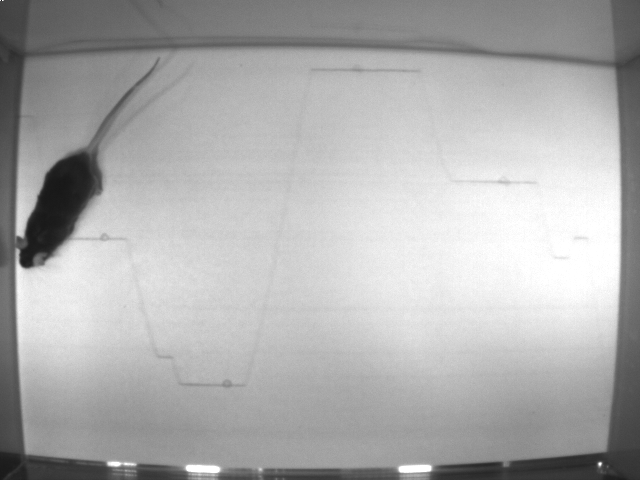

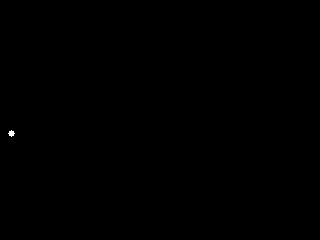

In [4]:
# reading & preprocessing labels
# (x,y) coordinates of each body part are provided in the label csv
# so we'll have to convert it into array/tensors
# each label coordinate & surrounding pixels are represented as 1
# the rest being 0 to produce a heatmap for each body part

RADIUS = 3  # influence range of each label
SHAPE = (240, 320)  # shape of label


images = []
labels = []

for img_file, row in zip(sorted(os.listdir(path+'frames')), 
            pd.read_csv(path+'CollectedData_Pranav.csv').iloc[2:,1:].to_numpy(dtype=float)):
    
    # read image into (1, 480, 640, 3) tesnor
    img = cv2.imread(os.path.join(path+'frames',img_file))
    img = tf.convert_to_tensor(img.reshape(1, 480, 640, 3), dtype=float)/255.0
    
    # process label coordinate into heatmap
    lbl = []
    for i in range(0, 8, 2):

        # read coordinates
        # downsample by 2 to reduce operations
        x = round(row[i] / 2)
        y = round(row[i+1] / 2)
        
        # create heatmap from coordinates
        heatmap = cv2.circle(np.zeros(SHAPE), (x, y), RADIUS, 255, -1)
        heatmap = tf.reshape(tf.convert_to_tensor(heatmap), (1, 240, 320, 1))
        lbl.append(heatmap)
    lbl = tf.concat(lbl, axis=3)  # each lbl: (1, 480, 640, 4)
    
    images.append(img)
    labels.append(lbl)

    # flip
    for axis in ([1],[2],[1,2]):
        new_img = tf.reverse(img, axis)
        new_lbl = tf.reverse(lbl, axis)
        images.append(new_img)
        labels.append(new_lbl)

# convert list of tensors into a large tensor
images = tf.concat(images, axis=0)
labels = tf.concat(labels, axis=0)

# cast labels into 1+4d, -> (None, 240, 320, 4, 2)
labels = tf.stack([1-labels, labels], axis=4)
print(labels.shape)
# each dim corresponds to
# (batch size, height, width,
# no. of feature, we have (snout, L.ear, R.ear, tail) here,
# probability of feature/non-feature)

# the last dimension is actually redundant, but required to work with
# tensorflow's categorical cross entropy loss
# (didn't manage to properly use the binary cross entropy loss, maybe
# a custom loss is required?)

cv2_imshow(images[0].numpy()[:,:,0] * 255)
cv2_imshow(labels[0].numpy()[:,:,0,1] * 255)
# (snout position)

In [5]:
test_images = images[:20]
test_labels = labels[:20]
images = images[20:]
labels = labels[20:]

# Train

In [6]:
class Model(tf.keras.Model):
    def __init__(self,):
        super().__init__(self)

        self.dropout = layers.Dropout(0.1)

        self.resNet = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                weights='imagenet', input_shape=(480, 640, 3), pooling=None)

        self.up = tf.keras.Sequential([
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(1024, 3, padding='same', activation='ReLU'),
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(512, 3, padding='same', activation='ReLU'),

            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(256, 3, padding='same', activation='ReLU'),
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(128, 3, padding='same', activation=None),
            layers.BatchNormalization(),
            layers.Activation('relu'),
        ])

        self.out = tf.keras.Sequential([
            layers.Conv2D(64, 3, padding='same', activation='ReLU'),
            layers.Conv2D(4, 1, padding='same', activation=None)
        ])
        self.activate = layers.Activation('softmax')

    def call(self, X, training=False):

        # add more augmentation
        #X = self.dropout(X, training=training)
        
        # save for later concat
        X0 = tf.nn.max_pool(X, ksize=2, strides=2, padding="VALID")

        # extract features with resNet, then upsample to 320*240
        X = self.resNet(X)
        X = self.up(X, training=training)

        # concat high resolution map
        X = tf.concat([X0, X], axis=3)
        X = self.out(X)

        # rearragne into binary format probability
        X = tf.stack([1-X, X], axis=4)
        X = self.activate(X)
        return X

In [7]:
gc.collect();

nn = Model()
print(nn(test_images[0:1]).shape)
nn.summary()

94781440/94765736 [==============================] - 1s 0us/step
(1, 240, 320, 4, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 resnet50 (Functional)       (None, 15, 20, 2048)      23587712  
                                                                 
 sequential (Sequential)     (1, 240, 320, 128)        25069952  
                                                                 
 sequential_1 (Sequential)   (1, 240, 320, 4)          75780     
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
Total params: 48,733,444
Trainable params: 48,680,068
Non-trainable params: 53,376
_________________________

In [ ]:
nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4, name='Adam'), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    )
nn.fit(x=images, y=labels, shuffle=True, batch_size=4, epochs=40, 
       verbose='auto', validation_data=(test_images, test_labels));
# larger batch size breaks colab

Epoch 1/40
111/111 [==============================] - 76s 639ms/step - loss: 0.0148 - val_loss: 0.0064
Epoch 2/40
111/111 [==============================] - 72s 653ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 3/40
111/111 [==============================] - 74s 667ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 4/40
111/111 [==============================] - 75s 675ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 5/40
111/111 [==============================] - 76s 680ms/step - loss: 9.3094e-04 - val_loss: 0.0033
Epoch 6/40
111/111 [==============================] - 76s 682ms/step - loss: 8.4059e-04 - val_loss: 0.0031
Epoch 7/40
111/111 [==============================] - 76s 684ms/step - loss: 7.7069e-04 - val_loss: 0.0034
Epoch 8/40
111/111 [==============================] - 76s 686ms/step - loss: 7.1889e-04 - val_loss: 0.0030
Epoch 9/40
111/111 [==============================] - 76s 686ms/step - loss: 6.9398e-04 - val_loss: 0.0034
Epoch 10/40
111/111 [==============================] 

In [ ]:
# save model
nn.save_weights('./checkpoints/my_checkpoint')
!zip -r checkpoint.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/my_checkpoint.data-00000-of-00001 (deflated 8%)
  adding: checkpoints/checkpoint (deflated 49%)
  adding: checkpoints/my_checkpoint.index (deflated 81%)


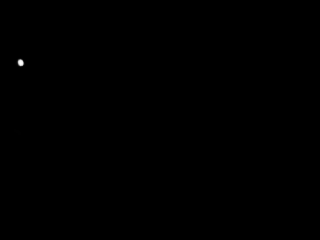

In [ ]:
cv2_imshow(nn(test_images[9:10])[0,:,:,1,1].numpy() * 255)

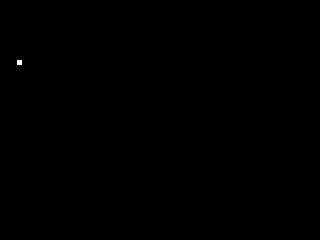

In [ ]:
cv2_imshow(test_labels[9:10][0,:,:,1,1].numpy() * 255)

In [ ]:
!rm -rf outputs
!mkdir outputs
for i in range(len(images)):
    for part in (0,1,2,3):
        y = nn(images[i:i+1])[0,:,:,part,1].numpy() * 255
        cv2.imwrite(f'outputs/{i}_{part}.jpg', y)
!zip -r outputs.zip outputs